<span style="text-decoration:underline">

# In-Depth Analysis:
</span>

<a id="import_packages"></a>

[Back To Top](#back_to_top)
<div class="alert alert-block alert-danger">

## Import necessary packages
</div>

In [1]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import string

# Import file reading packages
import json
import ast

from itertools import chain, starmap
import nltk
from nltk.corpus import stopwords

# Import Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
from os import path

import collections
import pickle

import scipy.stats
import scipy.signal as signal
import scipy.ndimage.filters as filters
import scipy.special as special
import scipy.optimize as optimize

import skimage.io
import skimage.transform

import cv2

import sys

sys.path.append('/Users/jeromegonzaga/.local/lib/python3.7/site-packages')

from libsvm import svmutil

<div class="alert alert-block alert-danger">

## Methods to be used in analysis
</div>

In [2]:
# method to change string to another datatype, if necessary and if possible

def str_to_other(string):

    # Return a dictionary or list if string looks like a dictionary or list
    try:
        if isinstance(string, dict):
            dictionary = string
            return dictionary
        else:
            try:
                dictionary = ast.literal_eval(string)
                return dictionary
            except:
                pass
    except:
        pass

    # Return an integer if string looks like an integer
    try:
        integer = int(string)
        return integer
    except:
        pass

    # Return a float if string looks like a float
    try:
        number = float(string)
        return number

    # Return a bool if string looks like a bool
    except:
        if string =='True' or string == 'true':
            return True
        elif string == 'False' or string == 'false':
            return False
        elif isinstance(string, bool):
            return string

    # If none of the above, return original string
        else:
            return string

In [3]:
### Method to create the x and y arrays for a CDF plot

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [4]:
# Method to extract the column names of 

def columns_from_nested_dict(df_dict):

    set_keys = []
    temp_dict = str_to_other(df_dict)

    for key in temp_dict:
        value = str_to_other(temp_dict[key])
        if isinstance(value, dict):
            set_keys.append(key)
            sub_keys = list(columns_from_nested_dict(value))
            set_keys.append(sub_keys)
        else:
            pass
        set_keys.append(key)
    
    return set_keys

<a id="create_dataframes"></a>

[Back To Top](#back_to_top)

## Create pandas DataFrames from each of the Yelp datasets

In [5]:
csv_filepath = '/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/yelp_dataset/'
csv_files = {'business':'business.csv', 'checkin':'checkin.csv', 'photo':'photo.csv',\
             'review':'review.csv', 'tip':'tip.csv', 'user':'user.csv'}

In [6]:
%%time
df_business = pd.read_csv(csv_filepath + csv_files['business'])
# df_photo = pd.read_csv(csv_filepath + csv_files['photo'], lineterminator='\n')
df_review = pd.read_csv(csv_filepath + csv_files['review'])
# df_tip = pd.read_csv(csv_filepath + csv_files['tip'])
df_user = pd.read_csv(csv_filepath + csv_files['user'], dtype = {'elite': str })
# df_checkin = pd.read_csv(csv_filepath + csv_files['checkin'])

<string>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 1min 15s, sys: 15.3 s, total: 1min 30s
Wall time: 1min 33s


In [7]:
# Drop rows where the 'hours' is blank, blank 'hours' most likely means the business closed down
df_business = df_business[df_business['hours'].notnull()]

In [8]:
# DataFrame of businesses and attributes
df_business = df_business.fillna('')
df_business = df_business.\
    drop(df_business.columns[df_business.columns.str.contains('Unnamed')], 1)
df_business = df_business.reset_index().drop('index', axis=1)

### Adjusting date format for some datasets

In [9]:
time_format = '%Y-%m-%d %H:%M'
df_review['datetime'] = pd.to_datetime(df_review['date'], format = time_format)

### Columns available to analyze

In [10]:
df_business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [11]:
df_review.columns

Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars', 'useful',
       'funny', 'cool', 'text', 'date', 'datetime'],
      dtype='object')

In [12]:
df_review.shape

(6685902, 11)

In [13]:
df_user.columns

Index(['Unnamed: 0', 'user_id', 'name', 'review_count', 'yelping_since',
       'useful', 'funny', 'cool', 'elite', 'friends', 'fans', 'average_stars',
       'compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos'],
      dtype='object')

[Back To Top](#back_to_top)

# Things to note:
- The more that a user posts reviews for businesses, the more review data there is to fit the ML model on, then the better the recommendations will get.

In [14]:
# Extracting the user_id, text and stars column from df_review
df_review_stars = df_review[['user_id','business_id', 'text', 'stars']]

# get list of reviewers with the most amount of reviews, sorted by number of reviews in df_review
list_users = df_review_stars[['user_id','stars']].groupby(['user_id']).count().\
    sort_values(by='stars', ascending=False).index

5.0      82
4.0    1373
3.0    2164
2.0     449
1.0      61
Name: stars, dtype: int64


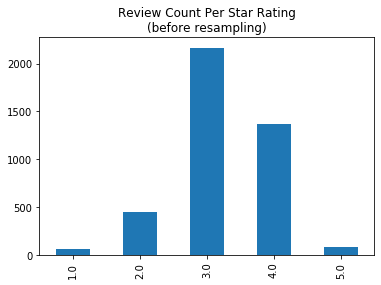

In [276]:
# user of interest (this can be changed to any user)
user_rank = 0
user_id = list_users[user_rank]

# get all the reviews from the user of interest
review_stars = df_review_stars[df_review_stars['user_id']==user_id].reset_index().\
    drop('index', axis=1) #.query('stars>=1.0')
print(review_stars['stars'].value_counts().sort_index(ascending=False))

review_stars['stars'].value_counts().sort_index().plot(kind='bar',
    title='Review Count Per Star Rating\n(before resampling)');

In [277]:
# Divide by star rating
df_stars_5 = review_stars[review_stars['stars'] == 5]
df_stars_4 = review_stars[review_stars['stars'] == 4]
df_stars_3 = review_stars[review_stars['stars'] == 3]
df_stars_2 = review_stars[review_stars['stars'] == 2]
df_stars_1 = review_stars[review_stars['stars'] == 1]

In [278]:
# create dataframes for sampling preprocessing
def CreateSamplingDF(df, count):
    if count == df.shape[0]:
        # return unaltered dataframe
        return df
    else:
        # return dataframe with randomly sampled data points added/removed
        return df.sample(count, replace=True)

Random sampling verification:
1.0    2164
2.0    2164
3.0    2164
4.0    2164
5.0    2164
Name: stars, dtype: int64


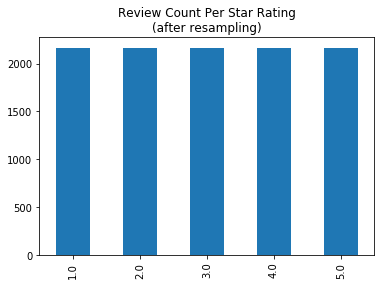

In [279]:
# Star rating count
count_stars_5, count_stars_4, count_stars_3, count_stars_2, count_stars_1 = review_stars['stars'].value_counts().\
    sort_index(ascending=False)

# determine how many samples for each category (this can be adjusted)
count = np.max([count_stars_5, count_stars_4, count_stars_3, count_stars_2, count_stars_1]).\
    round().astype(int)

# create over/under sampling dataframes
df_stars_5_over = CreateSamplingDF(df_stars_5, count)
df_stars_4_over = CreateSamplingDF(df_stars_4, count)
df_stars_3_over = CreateSamplingDF(df_stars_3, count)
df_stars_2_over = CreateSamplingDF(df_stars_2, count)
df_stars_1_over = CreateSamplingDF(df_stars_1, count)

df_stars_sampling = pd.concat([df_stars_5_over, df_stars_4_over, df_stars_3_over,
                          df_stars_2_over, df_stars_1_over], axis=0)

print('Random sampling verification:')
print(df_stars_sampling.stars.value_counts())

df_stars_sampling.stars.value_counts().plot(kind='bar', title='Review Count Per Star Rating\n(after resampling)');

review_stars_sampled = df_stars_sampling

<div class="alert alert-block alert-danger">

## USER-SPECIFIC TOP CATEGORIES
</div>

## Get User's Top Categories

In [280]:
user_business = df_review[df_review['user_id']==user_id]['business_id'].reset_index().drop('index', axis=1)

df_business_category = df_business[['business_id', 'categories']]

user_business_category = user_business.join(df_business_category.set_index('business_id'), on='business_id', \
                            how = 'inner', lsuffix = '', rsuffix = '_business')\
                            .reset_index().drop('index', axis=1)

In [281]:
categories_dict_user = {}
for row in range(user_business_category.shape[0]):
    categories_row = user_business_category.categories[row]
    categories_list = categories_row.strip('][').split(', ')
    
    for item in categories_list:
        if item in categories_dict_user.keys():
            categories_dict_user[item] += 1
        else:
            categories_dict_user[item] = 1

df_categories_user = pd.DataFrame(list(categories_dict_user.items()),
                             index = range(len(list(categories_dict_user.items()))))
df_categories_user.columns = ['category', 'count']

In [282]:
df_categories_user_subset = df_categories_user.sort_values(by = 'count', ascending = False).\
    set_index('category').head(15)

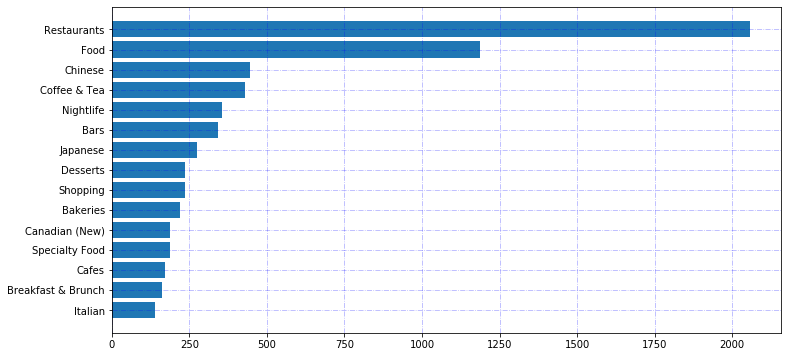

In [283]:
top_user_categories = list(df_categories_user_subset.index)
width = list(df_categories_user_subset['count'])

_ = plt.figure(figsize = (12,6))
_ = plt.barh(y = top_user_categories[::-1], width = width[::-1])
_ = plt.grid(linestyle = '-.', color = 'b', alpha = 0.3)
_ = plt.show()

In [284]:
top_user_categories

['Restaurants',
 'Food',
 'Chinese',
 'Coffee & Tea',
 'Nightlife',
 'Bars',
 'Japanese',
 'Desserts',
 'Shopping',
 'Bakeries',
 'Canadian (New)',
 'Specialty Food',
 'Cafes',
 'Breakfast & Brunch',
 'Italian']

In [316]:
df_reviews = review_stars_sampled.merge(df_business, left_on='business_id', right_on='business_id', 
                      suffixes=('_user', '_business'))

# provide primary & secondary list of categories to look for
category_primary = [top_user_categories[3]]
category_secondary = []

category_type = '|'.join(category_primary)

df_reviews_cat = df_reviews.loc[df_reviews['categories'].str.lower().str.contains((category_type).lower())]

category_type = '|'.join(category_secondary)

df_reviews_cat = df_reviews_cat.loc[df_reviews['categories'].str.lower().str.contains((category_type).lower())]

df = df_reviews_cat

In [317]:
y = df.stars_user.values
review_text = df.text.values
print(len(y))
print(review_text.shape[0])

848
848


In [318]:
import spacy
# spacy_nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()
from unicodedata import normalize

# Define default stopwords list
stoplist = spacy.lang.en.stop_words.STOP_WORDS

def replace_ptbr_char_by_word(word):
  # Will remove the encode token by token
    word = str(word)
    word = normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII')
    return word

def remove_pt_br_char_by_text(text):
  # Will remove the encode using the entire text
    text = str(text)
    text = " ".join(replace_ptbr_char_by_word(word) for word in text.split() if word not in stoplist)
    return text

for i in range(0,review_text.shape[0]):
    review_text[i] = remove_pt_br_char_by_text(review_text[i])

In [319]:
# Import necessary packages
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction import text

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import nltk.stem
from textblob import TextBlob

# Use TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(review_text, y, test_size = 0.4, random_state=42)

TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# additional stopwords to add as a result of tokenizing
additional_stopwords = ['a', 'an', 'the', 'it', 'they', 'them', 'and', 'are', 'but', 'for', 'was',
                        'have', 'i', 'in', 'is', 'my', 'of', 'on', 's', 't', 'that', 'this', 'to',
                        'with', 'you', 'as', 'at', 'be', 'get', 'had', 'if', 'just', 'me', 'not', 
                        'one', 'or', 'place', 'so', 'their', 'there', 'from', 'go', 'here', 'out', 
                        'time', 'up', 'we', 'were', 'when', 'your', 'about', 'been', 'can', 'm', 
                        've', 'what', 'all', 'back', 'because', 'by', 'do', 'has', 'will', 'would',
                        'she', 'some', 'which', 'also', 'am', 'come', 'how', 'know', 'made', 'make',
                        're', 'than', 'way', 'who', 'he', 'after', 'then', 'while', 'her', 'zero',
                        'york', 'yonge', 'yet', 'yelp', 'yelling', 'years ago', 'years', 'year',
                        'yeah', 'ya', 'y', 'x', 'wrote', 'written', 'writing review', 'writing',
                        'write review', 'write', 'world', 'works', 'working', 'workers', 'worker',
                        'worked', 'words', 'word', 'wooden', 'wood', 'wants', 'wanting', 'ago', 'ha',
                        'review', 'wa', 'want', 'work', 'le', 'u', ', ``', ', .', ', ,', ", 've", ", 's",
                        ", 're", ", 'm", ", 'll", ", 'd", ',', ') .', ') ,', ')', '(', "'ve .", "'ve",
                        'ha', 'le', 'u', 'wa', 'abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 
                        'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid',
                        'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 
                        'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 
                        'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 
                        'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 
                        'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher',
                        'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti',
                        'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 
                        'whi', 'yourselv',  'themselv', "'d", "'ll", "'m", "'re", "'s", 'anywh', 'becau', 
                        'cri', 'describ', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'seriou', 
                        'sever', 'somewh', 'veri', 'yell', 'yong', "n't"]
                       
stopwords = text.ENGLISH_STOP_WORDS.union(additional_stopwords)

# Instantiate Pipeline object: pl
pl = Pipeline([
        
        ('vec', CountVectorizer(ngram_range=(1,2),
                                analyzer='word',
                                token_pattern=TOKENS_ALPHANUMERIC,
                                stop_words=stopwords,#'english',
                                lowercase=True,
                                tokenizer=textblob_tokenizer
                               )),
        ('standard', StandardScaler(with_mean=False)),
        ('trunc', TruncatedSVD(n_components=500, n_iter=10)),
#         ('Random forest', RandomForestClassifier())
        ('clf', OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=500)))
    ])

In [320]:
# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_train, y_train)
print("\nTraining Accuracy: ", accuracy)

y_pred = pl.predict(X_test)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nTesting Accuracy: ", accuracy)


Training Accuracy:  1.0

Testing Accuracy:  0.8


In [321]:
# Import necessary modules
from sklearn.metrics import classification_report, confusion_matrix

# Generate the confusion matrix and classification report
class_report = classification_report(y_test, y_pred)
print(class_report)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        43
         2.0       1.00      0.90      0.95        41
         3.0       0.72      0.39      0.50        88
         4.0       0.63      0.90      0.74       103
         5.0       1.00      1.00      1.00        65

    accuracy                           0.80       340
   macro avg       0.87      0.84      0.84       340
weighted avg       0.82      0.80      0.79       340

[[43  0  0  0  0]
 [ 0 37  3  1  0]
 [ 0  0 34 54  0]
 [ 0  0 10 93  0]
 [ 0  0  0  0 65]]


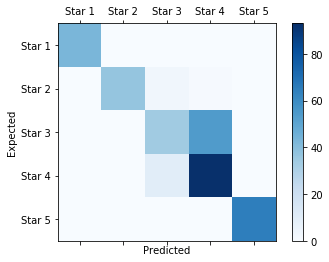

In [322]:
# Confusion matrix

labels = ['Star 1', 'Star 2', 'Star 3', 'Star 4', 'Star 5']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [323]:
# get top features used by the machine learning model

features = pl.named_steps.trunc

principle_component = pd.DataFrame(features.components_).transpose()

n_components = 20

for i in range(0,n_components):
    index_max = principle_component[i].idxmax()
    top_features = pl.named_steps['vec'].get_feature_names()
    len(top_features)
    print(str(i+1) + '.', top_features[index_max])

1. 1 lb
2. 2.50 delici
3. 3 fluffi
4. 3 winterlici
5. 10 soft
6. 10 oz
7. pie
8. rahier
9. 8.90
10. 3 bad
11. 8 sour
12. 12:30 pm
13. 3 day
14. 2 dare
15. 2 dare
16. live area
17. 3.99 person
18. 10.99
19. accept cash
20. hous coffe
